In [2]:
import numpy as np
from scipy import linalg
from scipy.special import logsumexp
import seaborn as sns
import pandas as pd
import os
from inspect import getmembers
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import dill
from equilibrator_api import ComponentContribution, Q_, Reaction
import requests
import xmltodict
import pint
import cvxpy as cp
import itertools
import copy

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

A + B -E1> C -E2> D

B -E3> F

A -E4> G

# Testing eQuilibrator

In [3]:
cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")



In [4]:
from equilibrator_api import Reaction
compound_ids = ["WATER", "ADP", "ATP", "Pi"]
compound_dict = {cid : cc.get_compound(f"metacyc.compound:{cid}") for cid in compound_ids}
atpase_reaction = Reaction({
    compound_dict["ATP"]: -1,
    compound_dict["WATER"]: -1,
    compound_dict["ADP"]: 1,
    compound_dict["Pi"]: 1,
})

In [5]:
standard_dg_prime = cc.standard_dg_prime(atpase_reaction)
standard_dg_prime

<Measurement(-29.144472212600157, 0.3042778553577678, kilojoule / mole)>

In [6]:
cytoplasmic_p_h = Q_(7.5)
cytoplasmic_ionic_strength = Q_("250 mM")
periplasmic_p_h = Q_(7.0)
periplasmic_ionic_strength = Q_("200 mM")
e_potential_difference = Q_("0.15 V")
cytoplasmic_reaction = "bigg.metabolite:pep = bigg.metabolite:g6p + bigg.metabolite:pyr"
periplasmic_reaction = "bigg.metabolite:glc__D = "

cc = ComponentContribution()
cc.p_h = cytoplasmic_p_h
cc.ionic_strength = cytoplasmic_ionic_strength
standard_dg_prime = cc.multicompartmental_standard_dg_prime(
    cc.parse_reaction_formula(cytoplasmic_reaction),
    cc.parse_reaction_formula(periplasmic_reaction),
    e_potential_difference=e_potential_difference,
    p_h_outer=periplasmic_p_h,
    ionic_strength_outer=periplasmic_ionic_strength,
)

print(standard_dg_prime)


(-44.8 +/- 0.6) kilojoule / mole


In [7]:
cc.get_compound_by_inchi("WQZGKKKJIJFFOK-GASJEMHNSA-N")

# Using eQuilibrator to generate equilibrium constants

In [8]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})
# Issue web service request:
r = s.get('https://websvc.biocyc.org/getxml?id=ECOLI:6PFRUCTPHOS-RXN&detail=low&fmt=json')

In [9]:
name = 'F16ALDOLASE-RXN'

r = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{name}&detail=low&fmt=json')
o = xmltodict.parse(r.content)['ptools-xml']
o['Reaction']['enzymatic-reaction']['Enzymatic-Reaction'][0]['@frameid']

'F16ALDOLASE-ENZRXN-CLASSI'

In [10]:

rxns_names = ['6PFRUCTPHOS-RXN', 'F16ALDOLASE-RXN', '2TRANSKETO-RXN', 'TRIOSEPISOMERIZATION-RXN']

rxns_dict = {}
stoich_dict = {}
regulation_dict = {}

for name in rxns_names:
    r = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{name}&detail=low&fmt=json')
    rxn = xmltodict.parse(r.content)['ptools-xml']

    rxn_dict = {}
    stoich_loop_dict = {}
    regulation_loop_dict = {}
    left = rxn['Reaction']['left']
    right = rxn['Reaction']['right'] 
    
    # i will know exact complex in model (connected to rxn), but for now will pick random
    enz_rxn = rxn['Reaction']['enzymatic-reaction']['Enzymatic-Reaction']
    
    if type(left) is dict:
        left = [left]
    
    if type(right) is dict:
        right = [right]
        
    if type(enz_rxn) is dict:
        enz_rxn = [enz_rxn]
    
    enz_rxn_id =  enz_rxn[0]['@frameid']
    re = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{enz_rxn_id}&detail=high&fmt=json')
    oe = xmltodict.parse(re.content)['ptools-xml']['Enzymatic-Reaction']['regulated-by']['Regulation']
    
    if type(oe) is dict:
        oe = [oe]
        
    # add regulators, target regulator directly with id to get info like irreversible, etc
    for regulator in oe:
        reg_name = regulator['regulator']['Compound']['@frameid']
        reg_type = regulator['mode']['#text']
        reg_type = 1 if reg_type == '+' else -1
        regulation_loop_dict[reg_name] = reg_type
    
    for mol in left:
        if type(mol) is dict:
            cid = mol['Compound']['@frameid']
            mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
            rxn_dict[mol_cc] = -1
            stoich_loop_dict[cid] = -1

    for mol in right:
        if type(mol) is dict:
            cid = mol['Compound']['@frameid']
            mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
            rxn_dict[mol_cc] =  1
            stoich_loop_dict[cid] = 1
    
    rxns_dict[name] = Reaction(rxn_dict)
    stoich_dict[name] = stoich_loop_dict
    regulation_dict[name] = regulation_loop_dict
    
rxns_dict

{'6PFRUCTPHOS-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x104dfd0a0>,
 'F16ALDOLASE-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x17d229c10>,
 '2TRANSKETO-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x289ddfa90>,
 'TRIOSEPISOMERIZATION-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x289df1550>}

In [11]:
(standard_dg_prime, dg_uncertainty) = cc.standard_dg_prime_multi(list(rxns_dict.values()), uncertainty_representation="cov")

In [12]:
standard_dg_prime

Magnitude,[-21.05010908198642 22.047924530096907 -5.946115510564027 -5.617742386692498]
Units,kilojoule/mole


In [13]:
dg_uncertainty

Magnitude,[[1.5398212990074922 -2.2167471180569773 0.6541085596545129 -0.004664260811860303] [-2.2167471180569773 5.286946034707553 -2.4322877177623594 -0.1291182736017488] [0.6541085596545129 -2.4322877177623594 5.547270812427002 -0.08893998540652082] [-0.004664260811860303 -0.1291182736017488 -0.08893998540652082 0.3010346102557717]]
Units,kilojoule2/mole2


In [14]:
R = 0.008314 # kJ/mol*K
T = 298.15 # K

In [15]:
dG = standard_dg_prime._magnitude

keq = np.exp(-dG/(R*T))
keq

array([4.87556287e+03, 1.37137368e-04, 1.10096201e+01, 9.64363243e+00])

# Calculating set of kinetic parameters with given equilibrium constants and arbitrary fluxes

In [16]:
Sd = pd.DataFrame(stoich_dict, dtype=np.int8).fillna(0).astype(np.int8)
# Sd = Sd.iloc[0:7, 0:2]

n_met = len(Sd.index)
n_rxn = len(Sd.columns)

Sd

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
FRUCTOSE-6P,-1,0,1,0
ATP,-1,0,0,0
PROTON,1,0,0,0
ADP,1,0,0,0
FRUCTOSE-16-DIPHOSPHATE,1,-1,0,0
DIHYDROXY-ACETONE-PHOSPHATE,0,1,0,1
GAP,0,1,1,-1
ERYTHROSE-4P,0,0,-1,0
XYLULOSE-5-PHOSPHATE,0,0,-1,0


In [17]:
dG = standard_dg_prime._magnitude

keq = np.exp(-dG/(R*T))
keq

K_eq = np.log(keq)
vE = np.array([100, 20, 30, 10])

K_eq[vE < 0] = 1/K_eq[vE < 0] 

lvE = np.log(np.abs(vE))

pd.DataFrame(np.array([K_eq, vE]), columns=Sd.columns, index=["$K_{eq}$", "$v$"])

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
$K_{eq}$,8.491991,-8.894527,2.398769,2.266298
$v$,100.000000,20.000000,30.000000,10.000000


In [18]:
# set up variables

S = np.array(Sd)
S = np.multiply(S, vE/np.abs(vE)).astype(np.int8)
S[S == -0] = 0
S_s = -np.copy(S)
S_p = np.copy(S) #reverse neg sign
S_s[S > 0] = 0
S_p[S < 0] = 0

S_s_nz = np.array(S_s.nonzero())
S_p_nz = np.array(S_p.nonzero())

# first coordinate, e.g. metabolites w nonzero substrate/product coeff across all reactions. also works as substrate indices. 
met_s_nz = S_s_nz[0, :]
met_p_nz = S_p_nz[0, :]

# second coordinate, e.g. reactions indices for those concentrations. works to index substrates as well. 
rxn_s_nz = S_s_nz[1, :]   
rxn_p_nz = S_p_nz[1, :]

# one dim is always 2
n_Km_s = np.max(met_s_nz.shape) 
n_Km_p = np.max(met_p_nz.shape)

c = cp.Variable(n_met)
Km_s = cp.Variable(n_Km_s)
Km_p = cp.Variable(n_Km_p)

cfwd = cp.Variable(n_rxn)
crev = cp.Variable(n_rxn)

# define Km positions by nonzero S matrix concentrations
y_s = c[met_s_nz] - Km_s
y_p = c[met_p_nz] - Km_p

# index 
met_s_nz

array([0, 1, 4, 6, 7, 8])

In [19]:
# number of saturation terms for sub, prod
n_alpha = np.sum(np.power(2, S_s.sum(axis=0)) - 1)
n_beta = np.sum(np.power(2, S_p.sum(axis=0)) - 1)

# saturation matrix setup
C_alpha = np.zeros([n_alpha, len(met_s_nz)])
C_beta = np.zeros([n_beta, len(met_p_nz)])

# to separate different reactions saturation terms. 
d_alpha = np.zeros(n_alpha, dtype=np.int8)
d_beta = np.zeros(n_beta, dtype=np.int8)


idx = 0

for i in range(n_rxn):
    
    # pick one reaction at a time (get substrate indicies)
    idx_cur_rxn = rxn_s_nz == i
    
    # generates all binary permutations minus the first one since that would result in -1
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    # replace zeros with saturation matrix
    C_alpha[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_alpha[idx:(idx+r)] = i
        
    idx += r # add row # 

idx = 0
    
for i in range(n_rxn):
    idx_cur_rxn = rxn_p_nz == i
    
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    C_beta[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_beta[idx:(idx+r)] = i
        
    idx += r # add row # 

In [20]:
C_alpha

array([[0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0.]])

In [21]:
n_lse_terms = np.max(np.power(2, S_s.sum(axis=0)) +  np.power(2, S_p.sum(axis=0)) - 2)
LSE_expr = []

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    LSE_expr.append(cp.hstack( [ lvE[i] + (C_alpha @ y_s)[d_alpha == i] - cp.multiply(np.ones(n_term_s), -S.T[i, S_s_idx] @ y_s[Km_s_idx]) - cfwd[i],  
                                 lvE[i] + (C_beta @ y_p)[d_beta == i] - cp.multiply(np.ones(n_term_p), -S.T[i, S_s_idx] @ y_s[Km_s_idx]) - cfwd[i],
                                 lvE[i] + 0 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s[Km_s_idx])  - cfwd[i],
                                 cp.multiply(np.ones(1), S.T[i, S_p_idx] @ y_p[Km_p_idx])  + crev[i]
                                 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s[Km_s_idx])  - cfwd[i]
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                             )
                   )  # remove +1 here, could also have cfwd outside objec. 
    
#LSE_expr = cp.vstack(LSE_expr)
LSE_expr

[Expression(AFFINE, UNKNOWN, (12,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,))]

In [22]:
l = 0.0000001
e = 0.00001
f = 0.0000001
reg =  cp.sum(cp.hstack([cfwd, crev, c])) + cp.sum(cp.hstack([-Km_s, -Km_p]))# regularization
reg2 = cp.norm1(cp.hstack([cfwd, crev, c])) + cp.norm1(cp.hstack([-Km_s, -Km_p]))# regularization
reg3 = cp.sum(cp.huber(cp.hstack([y_s, y_p]), 1))
#reg3 = cp.norm1(cp.hstack([y_s, y_p])) # take a look at this

loss = 0
for i in range(n_rxn):
    loss += cp.norm2(cp.pos(cp.log_sum_exp(LSE_expr[i])))
loss += l * reg 
loss += e * reg2
loss += f * reg3
# 

In [23]:
haldane = []
fwd_flux = []

for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    haldane.append(K_eq[i] == cfwd[i] - crev[i] + r[S_p_idx] @ Km_p[Km_p_idx] - (-r[S_s_idx]) @ Km_s[Km_s_idx])  # add minus since s matrix has minus
    fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ y_s[Km_s_idx] - (crev[i] + r[S_p_idx] @ y_p[Km_p_idx])  - (lvE[i])  >= 0)  # add minus since s matrix has minus

In [24]:
constr = [cp.hstack([cfwd, crev, c, Km_s, Km_p]) >= -12,
          cp.hstack([cfwd, crev, c, Km_s, Km_p]) <= 12, cfwd[0] == 7,
          ]

constr.extend(haldane)
constr.extend(fwd_flux)
constr.extend([S.T @ c <= K_eq])

In [25]:
p = cp.Problem(cp.Minimize(loss), constr)
p.solve(verbose=True, solver=cp.ECOS)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Apr 18 10:01:04 AM: Your problem has 31 variables, 12 constraints, and 0 parameters.
(CVXPY) Apr 18 10:01:04 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 18 10:01:04 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 18 10:01:05 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 18 10:01:05 AM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 18 10:01:05 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

0.0004813779651213706

## Checking correctness of result

In [26]:
cfwd.value

array([7.        , 3.25581073, 4.47957308, 2.99585499])

In [27]:
crev.value

array([-1.92262961e-05,  5.59492674e+00,  2.08075612e+00,  4.27516090e-04])

In [28]:
c.value

array([ 2.22231156e-07,  8.03083688e-06, -3.83222023e-06, -3.83222023e-06,
        2.19608329e+00, -9.69417048e+00, -1.59723269e-05,  7.35157061e-01,
        7.35157061e-01])

In [29]:
Km_s.value

array([-7.44709066e-01, -7.44465242e-01,  2.11470154e-05, -1.21641989e-08,
        9.72160120e-07,  9.72160120e-07])

In [30]:
Km_p.value

array([-2.27848459e-05,  4.67277371e-05,  4.67277371e-05,  2.70384610e-03,
       -6.55534788e+00, -7.29129636e-01, -4.24039958e-05, -2.27853236e-05])

## Checking Haldane and fwd/rev flux ratios are satisfied

In [31]:
for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    print("haldane", cfwd.value[i] - crev.value[i] + r[S_p_idx] @ Km_p.value[Km_p_idx] - (-r[S_s_idx]) @ Km_s.value[Km_s_idx] - K_eq[i] )
    # print(cfwd.value[i], (-r[S_s_idx]), y_s.value[Km_s_idx], crev.value[i], r[S_p_idx],  y_p.value[Km_p_idx])
    print("forward", cfwd.value[i] + (-r[S_s_idx]) @ y_s.value[Km_s_idx] - (crev.value[i] + r[S_p_idx] @ y_p.value[Km_p_idx]))

haldane -1.9953816376983013e-10
forward 6.295923461635894
haldane 2.0899371122595767e-10
forward 2.995742290234367
haldane -5.63642466033798e-11
forward 3.86909931448537
haldane -5.325162533154071e-11
forward 11.960452349894126


In [32]:
y_s.value

array([ 7.44709289e-01,  7.44473273e-01,  2.19606214e+00, -1.59601627e-05,
        7.35156089e-01,  7.35156089e-01])

In [33]:
y_p.value

array([ 2.30070771e-05, -5.05599573e-05, -5.05599573e-05,  2.19337945e+00,
       -3.13882259e+00, -8.96504084e+00,  2.64316689e-05,  6.81299667e-06])

## Checking that objective has been minimized.

Need to rearrange terms.

In [34]:
LSE_expr = []

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    
    LSE_expr.append(           [ (C_alpha @ y_s.value)[d_alpha == i] - np.multiply(np.ones(n_term_s), -S.T[i, S_s_idx] @ y_s.value[Km_s_idx]) - cfwd.value[i],  
                                 (C_beta @ y_p.value)[d_beta == i] - np.multiply(np.ones(n_term_p), -S.T[i, S_s_idx] @ y_s.value[Km_s_idx]) - cfwd.value[i],
                                 0 - np.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s.value[Km_s_idx])  - cfwd.value[i],
                                 np.multiply(np.ones(1), S.T[i, S_p_idx] @ y_p.value[Km_p_idx])  + crev.value[i]
                                 - np.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s.value[Km_s_idx])  - cfwd.value[i]
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                   )
    

est = np.zeros(4)    

for i, rxn in enumerate(LSE_expr):
    s = 0
    
    for term in rxn:
        s += np.sum(np.exp(term))
        
    est[i] = np.log(s)
    

# est is obj. 
print(np.array([np.exp(-est),np.exp(lvE)]))

[[ 84.60045977  10.25668824  18.68741751   9.99986912]
 [100.          20.          30.          10.        ]]


## How closely does the objective match our target kcats?

In [35]:
print(np.array([np.exp(-est),np.exp(lvE)]))

[[ 84.60045977  10.25668824  18.68741751   9.99986912]
 [100.          20.          30.          10.        ]]


Remarkable. 

## What do fluxes with reverse flow look like?

In [250]:
sat_expr = []
fwd_sat = np.zeros(n_rxn)
back_sat = np.zeros(n_rxn)
sat = np.zeros(n_rxn)

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]
    
    sat_expr.append(           [ (C_alpha @ y_s.value)[d_alpha == i] ,  
                                 (C_beta @ y_p.value)[d_beta == i],
                                 0,
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                   )
    fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[Km_s_idx])) # + cfwd.value[i]
    back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[Km_p_idx])) # + cfwd.value[i]
    
    

for i, rxn in enumerate(sat_expr):
    s = 0
    
    for term in rxn:
        s += np.sum(np.exp(term))
        
    sat[i] = (s)

In [251]:
fwd_sat/sat

array([0.09140335, 0.81160617, 0.34742853, 0.49996406])

In [252]:
back_sat/sat

array([1.84819175e-01, 3.91242311e-03, 7.98601209e-02, 6.38966298e-05])

In [253]:
np.exp(cfwd.value) * fwd_sat/sat 

array([100.23594632,  21.05358085,  30.64215805,  10.00050835])

In [254]:
np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat

array([100.05113069,  20.00091235,  30.00243667,  10.00044442])

In [255]:
np.exp(crev.value) * back_sat/sat

array([1.84815621e-01, 1.05266850e+00, 6.39721381e-01, 6.39239525e-05])

In [256]:
print('Substrate Km:', [f'{val:.3f}' for val in np.exp(Km_s.value)])
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])
print('Concentrations:', [f'{val:.3f}' for val in np.exp(c.value)])

Substrate Km: ['0.475', '0.475', '1.000', '1.000', '1.000', '1.000']
Product Km: ['1.000', '1.000', '1.000', '1.003', '0.001', '0.482', '1.000', '1.000']
Fwd kcat: ['1096.633', '25.941', '88.197', '20.002']
Rev kcat: ['1.000', '269.058', '8.011', '1.000']
Concentrations: ['1.000', '1.000', '1.000', '1.000', '8.990', '0.000', '1.000', '2.086', '2.086']


In [257]:
reconst_df = pd.DataFrame({"Reaction": Sd.columns, "True fluxes": np.abs(vE), "Estimated fluxes": np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat})
reconst_df = reconst_df.melt(id_vars="Reaction")
reconst_df

,Reaction,variable,value
0,6PFRUCTPHOS-RXN,True fluxes,100.000000
1,F16ALDOLASE-RXN,True fluxes,20.000000
2,2TRANSKETO-RXN,True fluxes,30.000000
3,TRIOSEPISOMERIZATION-RXN,True fluxes,10.000000
4,6PFRUCTPHOS-RXN,Estimated fluxes,100.051131
5,F16ALDOLASE-RXN,Estimated fluxes,20.000912
6,2TRANSKETO-RXN,Estimated fluxes,30.002437
7,TRIOSEPISOMERIZATION-RXN,Estimated fluxes,10.000444


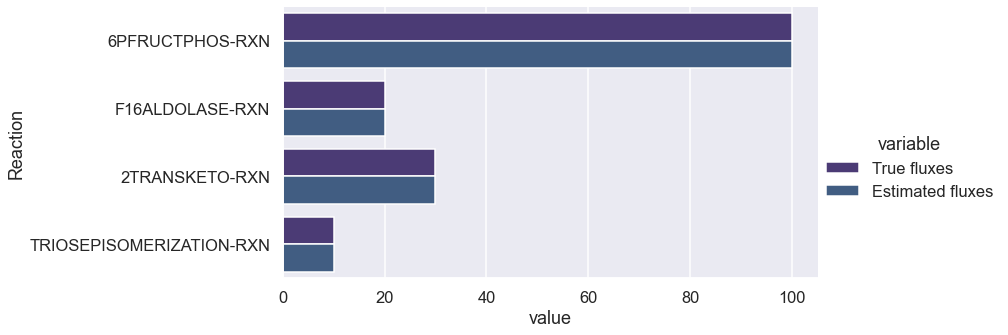

In [258]:
sns.catplot(y="Reaction", hue="variable", x="value", data=reconst_df, kind="bar", aspect=2.5)
plt.savefig("notebooks/fbagd/figures/reconstruction.png", dpi=300)

In [259]:
np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat

array([100.05113069,  20.00091235,  30.00243667,  10.00044442])

# Including inhibition

## I'm excluding some of the first operations as they are the same. 

In [260]:
dG = standard_dg_prime._magnitude

keq = np.exp(-dG/(R*T))
keq

K_eq = np.log(keq)
vE = np.array([100, -20, 30, 10])

K_eq[vE < 0] = -K_eq[vE < 0] 

lvE = np.log(np.abs(vE))

pd.DataFrame(np.array([K_eq, vE]), columns=Sd.columns, index=["$K_{eq}$", "$v$"])

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
$K_{eq}$,8.491991,8.894527,2.398769,2.266298
$v$,100.000000,-20.000000,30.000000,10.000000


In [261]:
Sd

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
FRUCTOSE-6P,-1,0,1,0
ATP,-1,0,0,0
PROTON,1,0,0,0
ADP,1,0,0,0
FRUCTOSE-16-DIPHOSPHATE,1,-1,0,0
DIHYDROXY-ACETONE-PHOSPHATE,0,1,0,1
GAP,0,1,1,-1
ERYTHROSE-4P,0,0,-1,0
XYLULOSE-5-PHOSPHATE,0,0,-1,0


Adding regulation dict.

In [262]:
Sr_min = pd.DataFrame(regulation_dict).fillna(0).astype(np.int8)

Sr = Sd.copy()
Sr.loc[:,:] = 0
Sr.loc[Sd.index.intersection(Sr_min.index), :] = Sr_min.loc[Sd.index.intersection(Sr_min.index), :]
Sr

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
FRUCTOSE-6P,1,0,0,0
ATP,0,0,0,0
PROTON,0,0,0,0
ADP,1,0,0,0
FRUCTOSE-16-DIPHOSPHATE,0,0,0,0
DIHYDROXY-ACETONE-PHOSPHATE,0,0,0,0
GAP,0,0,0,0
ERYTHROSE-4P,0,0,0,0
XYLULOSE-5-PHOSPHATE,0,0,0,0


In [263]:
# set up variables

S = np.array(Sd)
S = np.multiply(S, vE/np.abs(vE)).astype(np.int8)
S[S == -0] = 0
S_s = -np.copy(S)
S_p = np.copy(S) #reverse neg sign
S_s[S > 0] = 0
S_p[S < 0] = 0
S_i = np.copy(np.array(Sr) == -1)
S_a = np.copy(np.array(Sr) == 1)


S_s_nz = np.array(S_s.nonzero())
S_p_nz = np.array(S_p.nonzero())
S_i_nz = np.array(S_i.nonzero())
S_a_nz = np.array(S_a.nonzero())

# TODO Refactor all the below lines as one liners 
# first coordinate, e.g. metabolites w nonzero substrate/product coeff across all reactions. also works as substrate indices. 
met_s_nz = S_s_nz[0, :]
met_p_nz = S_p_nz[0, :]
met_i_nz = S_i_nz[0, :]
met_a_nz = S_a_nz[0, :]

# second coordinate, e.g. reactions indices for those concentrations. works to index substrates as well. 
rxn_s_nz = S_s_nz[1, :]   
rxn_p_nz = S_p_nz[1, :]
rxn_i_nz = S_i_nz[1, :]
rxn_a_nz = S_a_nz[1, :]

# one dim is always 2
n_Km_s = np.max(met_s_nz.shape) 
n_Km_p = np.max(met_p_nz.shape)
n_Km_i = np.max(met_i_nz.shape) 
n_Km_a = np.max(met_a_nz.shape)

c = cp.Variable(n_met)
Km_s = cp.Variable(n_Km_s)
Km_p = cp.Variable(n_Km_p)
Km_i = cp.Variable(n_Km_i) if n_Km_i else None
Km_a = cp.Variable(n_Km_a) if n_Km_a else None

cfwd = cp.Variable(n_rxn)
crev = cp.Variable(n_rxn)

# define Km positions by nonzero S matrix concentrations. Activation is reverse val of inhibition. 
y_s = c[met_s_nz] - Km_s
y_p = c[met_p_nz] - Km_p
y_i = c[met_i_nz] - Km_i if n_Km_i else None
y_a = -(c[met_a_nz] - Km_a) if n_Km_a else None

# saturation stacks
if n_Km_i and n_Km_a:
    y_f = cp.hstack((y_s, y_i, y_a))
    y_r = cp.hstack((y_p, y_i, y_a))
elif n_Km_i:
    y_f = cp.hstack((y_s, y_i))
    y_r = cp.hstack((y_p, y_i))
elif n_Km_a:
    y_f = cp.hstack((y_s, y_a))
    y_r = cp.hstack((y_p, y_a))
else:
    y_f = y_s
    y_r = y_p

In [264]:
S

array([[-1,  0,  1,  0],
       [-1,  0,  0,  0],
       [ 1,  0,  0,  0],
       [ 1,  0,  0,  0],
       [ 1,  1,  0,  0],
       [ 0, -1,  0,  1],
       [ 0, -1,  1, -1],
       [ 0,  0, -1,  0],
       [ 0,  0, -1,  0]], dtype=int8)

In [265]:
# number of saturation terms for sub, prod
S_s_comb = np.concatenate((S_s, S_i, S_a), axis=0)
S_p_comb = np.concatenate((S_p, S_i, S_a), axis=0)
n_alpha = np.sum(np.power(2, S_s_comb.sum(axis=0)) - 1)
n_beta = np.sum(np.power(2, S_p_comb.sum(axis=0)) - 1)

# saturation matrix setup, first sub, then inhib, then act. 
C_alpha = np.zeros([n_alpha, len(met_s_nz) + len(met_i_nz) + len(met_a_nz)])
C_beta = np.zeros([n_beta, len(met_p_nz) + len(met_i_nz) + len(met_a_nz)])

# to separate different reactions saturation terms to their individual reaction equations. 
d_alpha = np.zeros(n_alpha, dtype=np.int8)
d_beta = np.zeros(n_beta, dtype=np.int8)


idx = 0

for i in range(n_rxn):
    
    # pick one reaction at a time (get substrate indicies)
    #idx_cur_rxn = rxn_s_nz == i
    idx_cur_rxn = np.concatenate((rxn_s_nz == i, rxn_i_nz == i, rxn_a_nz == i))
    
    # generates all binary permutations minus the first one since that would result in -1
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    # replace zeros with saturation matrix
    C_alpha[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_alpha[idx:(idx+r)] = i
        
    idx += r # add row # 

idx = 0
    
for i in range(n_rxn):
    idx_cur_rxn = np.concatenate((rxn_p_nz == i, rxn_i_nz == i, rxn_a_nz == i))
    
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    C_beta[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_beta[idx:(idx+r)] = i
        
    idx += r # add row # 

In [266]:
n_lse_terms = np.max(np.power(2, S_s.sum(axis=0)) +  np.power(2, S_p.sum(axis=0)) - 2)
LSE_expr = []

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    LSE_expr.append(cp.hstack( [ lvE[i] + (C_alpha @ y_f)[d_alpha == i] - cp.multiply(np.ones(n_term_s), - S.T[i, S_s_idx] @ y_s[Km_s_idx]) - cfwd[i],  
                                 lvE[i] + (C_beta @ y_r)[d_beta == i] - cp.multiply(np.ones(n_term_p), - S.T[i, S_s_idx] @ y_s[Km_s_idx]) - cfwd[i],
                                 lvE[i] + 0 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s[Km_s_idx])  - cfwd[i],
                                 cp.multiply(np.ones(1), S.T[i, S_p_idx] @ y_p[Km_p_idx])  + crev[i]
                                 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s[Km_s_idx])  - cfwd[i]
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                             )
                   )  # remove +1 here, could also have cfwd outside objec. 
    
#LSE_expr = cp.vstack(LSE_expr)
LSE_expr

[Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,))]

In [267]:
l = 0.0000001
e = 0.00001
f = 0.0000001
reg =  cp.sum(cp.hstack([cfwd, crev, c])) + cp.sum(cp.hstack([-Km_s, -Km_p]))# regularization
reg2 = cp.norm1(cp.hstack([cfwd, crev, c])) + cp.norm1(cp.hstack([-Km_s, -Km_p]))# regularization
reg3 = cp.sum(cp.huber(cp.hstack([y_s, y_p]), 1))

if n_Km_i:
    reg += cp.sum(cp.hstack([-Km_i]))
if n_Km_a:
    reg += cp.sum(cp.hstack([-Km_a]))
#reg3 = cp.norm1(cp.hstack([y_s, y_p])) # take a look at this

loss = 0
for i in range(n_rxn):
    loss += cp.norm2(cp.pos(cp.log_sum_exp(LSE_expr[i])))
loss += l * reg 
loss += e * reg2
loss += f * reg3
# 

In [268]:
haldane = []
fwd_flux = []

for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    haldane.append(K_eq[i] == cfwd[i] - crev[i] + r[S_p_idx] @ Km_p[Km_p_idx] - (-r[S_s_idx]) @ Km_s[Km_s_idx])  # add minus since s matrix has minus
    fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ y_s[Km_s_idx] - (crev[i] + r[S_p_idx] @ y_p[Km_p_idx])  >= 0)  # add minus since s matrix has minus

In [269]:
constr = [cp.hstack([cfwd, crev, c, Km_s, Km_p]) >= -12,
          cp.hstack([cfwd, crev, c, Km_s, Km_p]) <= 12, 
          ]

if n_Km_i:
    constr.extend([Km_i >= -12, Km_i <= 12])
if n_Km_a:
    constr.extend([Km_a >= -12, Km_a <= 12])

constr.extend(haldane)
constr.extend(fwd_flux)
constr.extend([S.T @ c <= K_eq])

In [270]:
p = cp.Problem(cp.Minimize(loss), constr)
p.solve(verbose=False, solver=cp.ECOS)

0.0003037242788229941

In [271]:
print('Substrate Km:', [f'{val:.3f}' for val in np.exp(Km_s.value)])
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])
print('Concentrations:', [f'{val:.3f}' for val in np.exp(c.value)])

if n_Km_i:
    print('Inhibition Km:', [f'{val:.3f}' for val in np.exp(Km_i.value)])
if n_Km_a:
    print('Activation Km:', [f'{val:.3f}' for val in np.exp(Km_a.value)])

Substrate Km: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
Product Km: ['1.000', '1.254', '1.254', '1.254', '1.301', '1.000', '1.000']
Fwd kcat: ['2335.276', '84.350', '86.378', '28.344']
Rev kcat: ['0.946', '0.015', '7.846', '2.939']
Concentrations: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.251', '2.221', '2.221']
Activation Km: ['0.562', '0.583']


## Check equilibrium

In [272]:
S.T @ c.value <= K_eq

array([ True,  True,  True,  True])

In [273]:
S.T @ c.value

array([ 8.88268506e-07, -2.23548501e-01, -1.37238173e+00, -2.23559093e-01])

In [274]:
K_eq

array([8.49199084, 8.89452745, 2.39876944, 2.26629785])

## Check flux reconstruction with inhibition/activation

In [275]:
sat_expr = []
fwd_sat = np.zeros(n_rxn)
back_sat = np.zeros(n_rxn)
sat = np.zeros(n_rxn)

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]
    
    sat_expr.append(           [ (C_alpha @ y_f.value)[d_alpha == i] ,  
                                 (C_beta @ y_r.value)[d_beta == i],
                                 0,
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                   )
    fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[Km_s_idx])) # + cfwd.value[i]
    back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[Km_p_idx])) # + cfwd.value[i]
    
    

for i, rxn in enumerate(sat_expr):
    s = 0
    
    for term in rxn:
        s += np.sum(np.exp(term))
        
    sat[i] = (s)

In [276]:
np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat

array([100.48120083,  20.01743462,  30.00031371,  10.00005803])

In [277]:
Km_a.value

array([-0.57594296, -0.53950781])

Both enzymes have a much higher concentration than K_a, e.g. both are activated.

In [278]:
np.exp(-y_a.value)

array([1.77880537, 1.71516246])

About 99%.

# Reworking directionality to just rearrange terms, so we can add multiple substrate sets. One flux set to compare to previous

In [279]:
K_eq = np.log(keq)
#vE = np.array([100, 20, -30, -10])

# K_eq[vE < 0] = 1/K_eq[vE < 0] 

lvE = np.log(np.abs(vE))
pd.DataFrame(np.array([K_eq, vE, np.sign(vE, dtype=np.int8)]), columns=Sd.columns, index=["$K_{eq}$", "$v$", "sign"])

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
$K_{eq}$,8.491991,-8.894527,2.398769,2.266298
$v$,100.000000,-20.000000,30.000000,10.000000
sign,1.000000,-1.000000,1.000000,1.000000


In [280]:
# set up variables

S = np.array(Sd)
# S = np.multiply(S, vE/np.abs(vE)).astype(np.int8) # flips signs on reverse reactions, not needed
# S[S == -0] = 0
S_s = -np.copy(S) # reverse neg sign
S_p = np.copy(S) 
S_s[S > 0] = 0 # zeros products
S_p[S < 0] = 0 # zeros substrates
S_i = np.copy(np.array(Sr) == -1) # reaction direction does not matter
S_a = np.copy(np.array(Sr) == 1)


S_s_nz = np.array(S_s.nonzero())
S_p_nz = np.array(S_p.nonzero())
S_i_nz = np.array(S_i.nonzero())
S_a_nz = np.array(S_a.nonzero())

# TODO Refactor all the below lines as one liners 
# first coordinate, e.g. metabolites w nonzero substrate/product coeff across all reactions. also works as substrate indices. 
met_s_nz = S_s_nz[0, :]
met_p_nz = S_p_nz[0, :]
met_i_nz = S_i_nz[0, :]
met_a_nz = S_a_nz[0, :]

# second coordinate, e.g. reactions indices for those concentrations. works to index substrates as well. 
rxn_s_nz = S_s_nz[1, :]   
rxn_p_nz = S_p_nz[1, :]
rxn_i_nz = S_i_nz[1, :]
rxn_a_nz = S_a_nz[1, :]

# one dim is always 2
n_Km_s = np.max(met_s_nz.shape) 
n_Km_p = np.max(met_p_nz.shape)
n_Km_i = np.max(met_i_nz.shape) 
n_Km_a = np.max(met_a_nz.shape)

c = cp.Variable(n_met)
Km_s = cp.Variable(n_Km_s)
Km_p = cp.Variable(n_Km_p)
Km_i = cp.Variable(n_Km_i) if n_Km_i else None
Km_a = cp.Variable(n_Km_a) if n_Km_a else None

cfwd = cp.Variable(n_rxn)
crev = cp.Variable(n_rxn)

# define Km positions by nonzero S matrix concentrations. Activation is reverse val of inhibition. 
y_s = c[met_s_nz] - Km_s
y_p = c[met_p_nz] - Km_p
y_i = c[met_i_nz] - Km_i if n_Km_i else None
y_a = -(c[met_a_nz] - Km_a) if n_Km_a else None

# saturation stacks
if n_Km_i and n_Km_a:
    y_f = cp.hstack((y_s, y_i, y_a))
    y_r = cp.hstack((y_p, y_i, y_a))
elif n_Km_i:
    y_f = cp.hstack((y_s, y_i))
    y_r = cp.hstack((y_p, y_i))
elif n_Km_a:
    y_f = cp.hstack((y_s, y_a))
    y_r = cp.hstack((y_p, y_a))
else:
    y_f = y_s
    y_r = y_p

In [281]:
S

array([[-1,  0,  1,  0],
       [-1,  0,  0,  0],
       [ 1,  0,  0,  0],
       [ 1,  0,  0,  0],
       [ 1, -1,  0,  0],
       [ 0,  1,  0,  1],
       [ 0,  1,  1, -1],
       [ 0,  0, -1,  0],
       [ 0,  0, -1,  0]], dtype=int8)

In [282]:
# number of saturation terms for sub, prod
S_s_comb = np.concatenate((S_s, S_i, S_a), axis=0)
S_p_comb = np.concatenate((S_p, S_i, S_a), axis=0)
n_alpha = np.sum(np.power(2, S_s_comb.sum(axis=0)) - 1)
n_beta = np.sum(np.power(2, S_p_comb.sum(axis=0)) - 1)

# saturation matrix setup, first sub, then inhib, then act. 
C_alpha = np.zeros([n_alpha, len(met_s_nz) + len(met_i_nz) + len(met_a_nz)])
C_beta = np.zeros([n_beta, len(met_p_nz) + len(met_i_nz) + len(met_a_nz)])

# to separate different reactions saturation terms to their individual reaction equations. 
d_alpha = np.zeros(n_alpha, dtype=np.int8)
d_beta = np.zeros(n_beta, dtype=np.int8)


idx = 0

for i in range(n_rxn):
    
    # pick one reaction at a time (get substrate indicies)
    #idx_cur_rxn = rxn_s_nz == i
    idx_cur_rxn = np.concatenate((rxn_s_nz == i, rxn_i_nz == i, rxn_a_nz == i))
    
    # generates all binary permutations minus the first one since that would result in -1
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    # replace zeros with saturation matrix
    C_alpha[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_alpha[idx:(idx+r)] = i
        
    idx += r # add row # 

idx = 0
    
for i in range(n_rxn):
    idx_cur_rxn = np.concatenate((rxn_p_nz == i, rxn_i_nz == i, rxn_a_nz == i))
    
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    C_beta[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_beta[idx:(idx+r)] = i
        
    idx += r # add row # 

In [283]:
n_lse_terms = np.max(np.power(2, S_s.sum(axis=0)) +  np.power(2, S_p.sum(axis=0)) - 2)
LSE_expr = []

sign = np.sign(vE)
lvE = np.log(sign * vE)

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    if sign[i] == 1:
        LSE_expr.append(cp.hstack( [ lvE[i] + (C_alpha @ y_f)[d_alpha == i] - cp.multiply(np.ones(n_term_s), - S.T[i, S_s_idx] @ y_s[Km_s_idx]) - cfwd[i],  
                                     lvE[i] + (C_beta @ y_r)[d_beta == i] - cp.multiply(np.ones(n_term_p), - S.T[i, S_s_idx] @ y_s[Km_s_idx]) - cfwd[i],
                                     lvE[i] + 0 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s[Km_s_idx])  - cfwd[i],
                                     cp.multiply(np.ones(1), S.T[i, S_p_idx] @ y_p[Km_p_idx])  + crev[i]
                                     - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s[Km_s_idx])  - cfwd[i]
                                     #-1*np.ones(n_lse_terms - n_term + 1) 
                                   ]
                                 )
                       )  # remove +1 here, could also have cfwd outside objec. 
        
    # keep saturation term the same, switch around fwd and rev terms. flip all signs with S matrix since it's signed. 
    if sign[i] == -1:
        LSE_expr.append(cp.hstack( [ lvE[i] + (C_alpha @ y_f)[d_alpha == i] - cp.multiply(np.ones(n_term_s), S.T[i, S_p_idx] @ y_p[Km_p_idx]) - crev[i],  
                                     lvE[i] + (C_beta @ y_r)[d_beta == i] - cp.multiply(np.ones(n_term_p), S.T[i, S_p_idx] @ y_p[Km_p_idx]) - crev[i],
                                     lvE[i] + 0 - cp.multiply(np.ones(1), S.T[i, S_p_idx] @ y_p[Km_p_idx]) - crev[i],
                                     cp.multiply(np.ones(1), - S.T[i, S_s_idx] @ y_s[Km_s_idx])  + cfwd[i]
                                     - cp.multiply(np.ones(1), S.T[i, S_p_idx] @ y_p[Km_p_idx]) - crev[i],
                                     #-1*np.ones(n_lse_terms - n_term + 1) 
                                   ]
                                 )
                       )
    
#LSE_expr = cp.vstack(LSE_expr)
LSE_expr

[Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,))]

In [284]:
l = 0.0000001
e = 0.00001
f = 0.0000001
reg =  cp.sum(cp.hstack([cfwd, crev, c])) + cp.sum(cp.hstack([-Km_s, -Km_p]))# regularization
reg2 = cp.norm1(cp.hstack([cfwd, crev, c])) + cp.norm1(cp.hstack([-Km_s, -Km_p]))# regularization
reg3 = cp.sum(cp.huber(cp.hstack([y_s, y_p]), 1))

if n_Km_i:
    reg += cp.sum(cp.hstack([-Km_i]))
if n_Km_a:
    reg += cp.sum(cp.hstack([-Km_a]))
#reg3 = cp.norm1(cp.hstack([y_s, y_p])) # take a look at this

loss = 0
for i in range(n_rxn):
    loss += cp.norm2(cp.pos(cp.log_sum_exp(LSE_expr[i])))
loss += l * reg 
loss += e * reg2
loss += f * reg3
# 

In [285]:
constr = [cp.hstack([cfwd, crev, c, Km_s, Km_p]) >= -12,
          cp.hstack([cfwd, crev, c, Km_s, Km_p]) <= 12,
          ]

if n_Km_i:
    constr.extend([Km_i >= -12, Km_i <= 12])
if n_Km_a:
    constr.extend([Km_a >= -12, Km_a <= 12])



In [286]:
haldane = []
fwd_flux = []
equilibrium = []

for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    haldane.append(K_eq[i] == cfwd[i] - crev[i] + r[S_p_idx] @ Km_p[Km_p_idx] - (-r[S_s_idx]) @ Km_s[Km_s_idx])  # add minus since s matrix has minus
    
    if sign[i] == 1:
        fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ y_s[Km_s_idx] - (crev[i] + r[S_p_idx] @ y_p[Km_p_idx])  >= 0)  # add minus since s matrix has minus
        # equilibrium.append(r @ c <= K_eq[i])
        
    if sign[i] == -1:
        fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ y_s[Km_s_idx] - (crev[i] + r[S_p_idx] @ y_p[Km_p_idx])  <= 0)  # add minus since s matrix has minus
        # equilibrium.append(r @ c >= K_eq[i])
        
        
constr.extend(haldane)
constr.extend(fwd_flux)
# constr.extend(equilibrium)
constr.extend([cp.multiply(S.T @ c, sign)  <= cp.multiply(K_eq, sign)])

In [287]:
p = cp.Problem(cp.Minimize(loss), constr)
p.solve(verbose=False, solver=cp.ECOS)

0.0003037242788229874

In [288]:
print('Substrate Km:', [f'{val:.3f}' for val in np.exp(Km_s.value)])
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])
print('Concentrations:', [f'{val:.3f}' for val in np.exp(c.value)])

if n_Km_i:
    print('Inhibition Km:', [f'{val:.3f}' for val in np.exp(Km_i.value)])
if n_Km_a:
    print('Activation Km:', [f'{val:.3f}' for val in np.exp(Km_a.value)])

Substrate Km: ['1.000', '1.000', '1.301', '1.000', '1.000', '1.000']
Product Km: ['1.000', '1.254', '1.254', '1.254', '1.000', '1.000', '1.000', '1.000']
Fwd kcat: ['2335.276', '0.015', '86.378', '28.344']
Rev kcat: ['0.946', '84.350', '7.846', '2.939']
Concentrations: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.251', '2.221', '2.221']
Activation Km: ['0.562', '0.583']


In [289]:
# Substrate Km: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
# Product Km: ['1.000', '1.254', '1.254', '1.254', '1.301', '1.000', '1.000']
# Fwd kcat: ['2335.276', '84.350', '86.378', '28.344']
# Rev kcat: ['0.946', '0.015', '7.846', '2.939']
# Concentrations: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.251', '2.221', '2.221']
# Activation Km: ['0.562', '0.583']


## Check equilibrium

In [75]:
np.multiply(S.T @ c.value, sign)

array([ 8.88268506e-07, -2.23548501e-01, -1.37238173e+00, -2.23559093e-01])

In [76]:
np.multiply(K_eq, sign)

array([8.49199084, 8.89452745, 2.39876944, 2.26629785])

## Check flux reconstruction with inhibition/activation

In [77]:
sat_expr = []
fwd_sat = np.zeros(n_rxn)
back_sat = np.zeros(n_rxn)
sat = np.zeros(n_rxn)

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]
    
    sat_expr.append(           [ (C_alpha @ y_f.value)[d_alpha == i] ,  
                                 (C_beta @ y_r.value)[d_beta == i],
                                 0,
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                   )
    fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[Km_s_idx])) # + cfwd.value[i]
    back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[Km_p_idx])) # + cfwd.value[i]
    
    

for i, rxn in enumerate(sat_expr):
    s = 0
    
    for term in rxn:
        s += np.sum(np.exp(term))
        
    sat[i] = (s)

In [78]:
np.exp(cfwd.value) * fwd_sat/sat

array([1.00501814e+02, 2.19546227e-03, 3.07073675e+01, 1.09042591e+01])

In [79]:
- np.exp(crev.value) * back_sat/sat

array([ -0.0206134 , -20.01963009,  -0.70705377,  -0.90420111])

In [80]:
np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat

array([100.48120083, -20.01743462,  30.00031371,  10.00005803])

In [81]:
Km_a.value

array([-0.57594296, -0.53950781])

Both enzymes have a much higher concentration than K_a, e.g. both are activated.

In [82]:
np.exp(-y_a.value)

array([1.77880537, 1.71516246])

# Adding flux set

In [83]:
Sd = pd.DataFrame(stoich_dict, dtype=np.int8).fillna(0).astype(np.int8)
# Sd = Sd.iloc[0:7, 0:2]

n_met = len(Sd.index)
n_rxn = len(Sd.columns)

Sd

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
FRUCTOSE-6P,-1,0,1,0
ATP,-1,0,0,0
PROTON,1,0,0,0
ADP,1,0,0,0
FRUCTOSE-16-DIPHOSPHATE,1,-1,0,0
DIHYDROXY-ACETONE-PHOSPHATE,0,1,0,1
GAP,0,1,1,-1
ERYTHROSE-4P,0,0,-1,0
XYLULOSE-5-PHOSPHATE,0,0,-1,0


In [84]:
K_eq = np.log(keq)
K_eq_mod = K_eq[:, np.newaxis].T
vE = np.array([[90, 70, -30, 50], [100, 100, 30, 50], [110, 60, 75, 50]])

n_flux_set = vE.shape[0]

# K_eq[vE < 0] = 1/K_eq[vE < 0] 

lvE = np.log(np.abs(vE))
pd.DataFrame(np.concatenate([K_eq_mod, vE, np.sign(vE, dtype=np.int8)]), columns=Sd.columns, 
             index=["$K_{eq}$", "$v_1$", "$v_2$", "$v_3$", "sign 1", "sign 2", "sign 3"])

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
$K_{eq}$,8.491991,-8.894527,2.398769,2.266298
$v_1$,90.000000,70.000000,-30.000000,50.000000
$v_2$,100.000000,100.000000,30.000000,50.000000
$v_3$,110.000000,60.000000,75.000000,50.000000
sign 1,1.000000,1.000000,-1.000000,1.000000
sign 2,1.000000,1.000000,1.000000,1.000000
sign 3,1.000000,1.000000,1.000000,1.000000


In [85]:
# set up variables

S = np.array(Sd)
# S = np.multiply(S, vE/np.abs(vE)).astype(np.int8) # flips signs on reverse reactions, not needed
# S[S == -0] = 0
S_s = -np.copy(S) # reverse neg sign
S_p = np.copy(S) 
S_s[S > 0] = 0 # zeros products
S_p[S < 0] = 0 # zeros substrates
S_i = np.copy(np.array(Sr) == -1) # reaction direction does not matter
S_a = np.copy(np.array(Sr) == 1)


S_s_nz = np.array(S_s.nonzero())
S_p_nz = np.array(S_p.nonzero())
S_i_nz = np.array(S_i.nonzero())
S_a_nz = np.array(S_a.nonzero())

# TODO Refactor all the below lines as one liners 
# first coordinate, e.g. metabolites w nonzero substrate/product coeff across all reactions. also works as substrate indices. 
met_s_nz = S_s_nz[0, :]
met_p_nz = S_p_nz[0, :]
met_i_nz = S_i_nz[0, :]
met_a_nz = S_a_nz[0, :]

# second coordinate, e.g. reactions indices for those concentrations. works to index substrates as well. 
rxn_s_nz = S_s_nz[1, :]   
rxn_p_nz = S_p_nz[1, :]
rxn_i_nz = S_i_nz[1, :]
rxn_a_nz = S_a_nz[1, :]

# one dim is always 2
n_Km_s = np.max(met_s_nz.shape) 
n_Km_p = np.max(met_p_nz.shape)
n_Km_i = np.max(met_i_nz.shape) 
n_Km_a = np.max(met_a_nz.shape)

c = cp.Variable([n_met, n_flux_set])
Km_s = cp.Variable(n_Km_s)
Km_p = cp.Variable(n_Km_p)
Km_i = cp.Variable(n_Km_i) if n_Km_i else None
Km_a = cp.Variable(n_Km_a) if n_Km_a else None

cfwd = cp.Variable(n_rxn)
crev = cp.Variable(n_rxn)

# define y vecs
y_s_t = []
y_p_t = []
y_i_t = []
y_a_t = []

# define Km positions by nonzero S matrix concentrations. Activation is reverse val of inhibition.
# TODO Add molecularity here.
for i in range(n_flux_set):
    y_s_t.append(c[met_s_nz, i] - Km_s)
    y_p_t.append(c[met_p_nz, i] - Km_p)
    y_i_t.append(c[met_i_nz, i] - Km_i if n_Km_i else None)
    y_a_t.append(-(c[met_a_nz, i] - Km_a) if n_Km_a else None)

y_s = cp.vstack(y_s_t)
y_p = cp.vstack(y_p_t)
y_i = cp.vstack(y_i_t)
y_a = cp.vstack(y_a_t)
    
# saturation stacks
y_f_vec = [y_s]
y_r_vec = [y_p]
if n_Km_i:
    y_f_vec.append(y_i)
    y_r_vec.append(y_i)
if n_Km_a:
    y_f_vec.append(y_a)
    y_r_vec.append(y_a)    

y_f = cp.hstack(y_f_vec)
y_r = cp.hstack(y_r_vec)

In [86]:
# number of saturation terms for sub, prod
S_s_comb = np.concatenate((S_s, S_i, S_a), axis=0)
S_p_comb = np.concatenate((S_p, S_i, S_a), axis=0)
n_alpha = np.sum(np.power(2, S_s_comb.sum(axis=0)) - 1)
n_beta = np.sum(np.power(2, S_p_comb.sum(axis=0)) - 1)

# saturation matrix setup, first sub, then inhib, then act. 
C_alpha = np.zeros([n_alpha, len(met_s_nz) + len(met_i_nz) + len(met_a_nz)])
C_beta = np.zeros([n_beta, len(met_p_nz) + len(met_i_nz) + len(met_a_nz)])

# to separate different reactions saturation terms to their individual reaction equations. 
d_alpha = np.zeros(n_alpha, dtype=np.int8)
d_beta = np.zeros(n_beta, dtype=np.int8)


idx = 0

for i in range(n_rxn):
    
    # pick one reaction at a time (get substrate indicies)
    #idx_cur_rxn = rxn_s_nz == i
    # TODO This does not properly multiply by molecularity. Alternatively, generate C_alpha and
    # TODO beta without molecularity (first ==1) and then multiply by molecularity in the end.
    idx_cur_rxn = np.concatenate((rxn_s_nz == i, rxn_i_nz == i, rxn_a_nz == i))
    
    # generates all binary permutations minus the first one since that would result in -1
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    # replace zeros with saturation matrix
    C_alpha[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_alpha[idx:(idx+r)] = i
        
    idx += r # add row # 

idx = 0
    
for i in range(n_rxn):
    idx_cur_rxn = np.concatenate((rxn_p_nz == i, rxn_i_nz == i, rxn_a_nz == i))
    
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    C_beta[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_beta[idx:(idx+r)] = i
        
    idx += r # add row # 

In [87]:
n_lse_terms = np.max(np.power(2, S_s.sum(axis=0)) +  np.power(2, S_p.sum(axis=0)) - 2)
LSE_expr = []
denom_expr = []

sign = np.sign(vE)
lvE = np.log(sign * vE)

for j in range(n_flux_set):
    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)

        n_term_s = np.sum(d_alpha == i) 
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p

        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
        
        if sign[j, i] == 1:
            LSE_expr.append(cp.hstack( [ 
                                         lvE[j, i] + (C_alpha @ cp.vec(y_f[j, :]))[d_alpha == i] 
                                            - cp.multiply(np.ones(n_term_s), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) - cfwd[i],  
                                         lvE[j, i] + (C_beta @ cp.vec(y_r[j, :]))[d_beta == i] 
                                            - cp.multiply(np.ones(n_term_p), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) - cfwd[i],
                
                                         lvE[j, i] + 0 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  - cfwd[i],
                
                                         cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  + crev[i]
                                            - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  - cfwd[i],
                
                                       ]
                                     )
                           )  # remove +1 here, could also have cfwd outside objec.
            
            denom_expr.append(cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) + cfwd[i],)
            

        # keep saturation term the same, switch around fwd and rev terms. flip all signs with S matrix since it's signed. 
        if sign[j, i] == -1:
            LSE_expr.append(cp.hstack( [ lvE[j, i] + (C_alpha @ cp.vec(y_f[j, :]))[d_alpha == i] 
                                            - cp.multiply(np.ones(n_term_s), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],  
                                        
                                         lvE[j, i] + (C_beta @ cp.vec(y_r[j, :]))[d_beta == i] 
                                            - cp.multiply(np.ones(n_term_p), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],
                                        
                                         lvE[j, i] + 0 - cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],
                                        
                                         cp.multiply(np.ones(1), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  + cfwd[i]
                                            - cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],
                                        
                                       ]
                                     )
                           )
            
            denom_expr.append(cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) + crev[i])
            

#LSE_expr = cp.vstack(LSE_expr)
LSE_expr

[Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,)),
 Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,)),
 Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,))]

In [88]:
l = 0.001
e = 0.001
f = 0.000001
reg =  cp.sum(cp.hstack([cfwd, crev, cp.vec(c)])) + cp.sum(cp.hstack([-Km_s, -Km_p])) # regularization
reg2 = cp.norm1(cp.hstack([cfwd, crev, cp.vec(c)])) + cp.norm1(cp.hstack([-Km_s, -Km_p])) # regularization
reg3 = cp.sum(cp.huber(cp.hstack([y_s, y_p]), 1)) # issue with matrix

if n_Km_i:
    reg += cp.sum(cp.hstack([-Km_i]))
if n_Km_a:
    reg += cp.sum(cp.hstack([-Km_a]))
#reg3 = cp.norm1(cp.hstack([y_s, y_p])) # take a look at this

loss = 0
for i in range(len(LSE_expr)):
    loss += cp.norm1(cp.pos(cp.log_sum_exp(LSE_expr[i])))
for i in range(len(denom_expr)):
    loss += 0.01 * denom_expr[i]
loss += l * reg 
loss += e * reg2
loss += f * reg3
# 

In [89]:
constr = [cp.hstack([cfwd, crev, cp.vec(c), Km_s, Km_p]) >= -12,
          cp.hstack([cfwd, crev, cp.vec(c), Km_s, Km_p]) <= 12,
          ]

if n_Km_i:
    constr.extend([Km_i >= -12, Km_i <= 12])
if n_Km_a:
    constr.extend([Km_a >= -12, Km_a <= 12])



In [90]:
constr.extend([Km_a[0] == -1])

In [91]:
haldane = []
fwd_flux = []

for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

    haldane.append(K_eq[i] == cfwd[i] - crev[i] + r[S_p_idx] @ Km_p[Km_p_idx] - (-r[S_s_idx]) @ Km_s[Km_s_idx])

for j in range(n_flux_set):
    for i, r in enumerate(S.T):
        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        if sign[j, i] == 1:
            fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ cp.vec(y_s[j, Km_s_idx]) - (crev[i] + r[S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  >= 0)  # add minus since s matrix has minus
            # equilibrium.append(r @ c <= K_eq[i])

        if sign[j, i] == -1:
            fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ cp.vec(y_s[j, Km_s_idx]) - (crev[i] + r[S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  <= 0)  # add minus since s matrix has minus
            # equilibrium.append(r @ c >= K_eq[i])
        
        
    constr.extend([cp.multiply(S.T @ cp.vec(c[:, j]), sign[j, :])  <= cp.multiply(K_eq, sign[j, :])])
        
constr.extend(haldane)
constr.extend(fwd_flux)

In [92]:
p = cp.Problem(cp.Minimize(loss), constr)
p.solve(verbose=False, solver=cp.ECOS)

0.6597879150163977

In [93]:
print('Substrate Km:', [f'{val:.3f}' for val in np.exp(Km_s.value)])
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])

concs = np.exp(c.value).T
for row in concs:
    print('Concentration:', [f'{val:.4f}' for val in row])

if n_Km_i:
    print('Inhibition Km:', [f'{val:.3f}' for val in np.exp(Km_i.value)])
if n_Km_a:
    print('Activation Km:', [f'{val:.3f}' for val in np.exp(Km_a.value)])

Substrate Km: ['76.921', '9.298', '11.451', '1.059', '3.384', '3.384']
Product Km: ['105.634', '1.000', '4.070', '19.201', '0.033', '0.033', '1.000', '1.000']
Fwd kcat: ['44626.461', '1325.333', '5114.664', '847.467']
Rev kcat: ['1.000', '27646.576', '4284.548', '2.719']
Concentration: ['13.3903', '0.1482', '0.0002', '0.1624', '0.6842', '0.0000', '0.0664', '0.0006', '0.0006']
Concentration: ['2.5741', '1.0000', '0.0002', '0.1599', '1.0000', '0.0000', '0.0664', '0.3197', '0.3197']
Concentration: ['2.7533', '1.0000', '0.0002', '0.1609', '0.5823', '0.0000', '0.0664', '0.5041', '0.5041']
Activation Km: ['0.368', '0.003']


In [94]:
for v in LSE_expr:
    #print(v.value)
    print(logsumexp(v.value))

-1.030589966033446e-06
-1.5818914703147335e-07
-1.4069550624551397e-07
-1.6061000444184126e-07
-9.194091360464896e-07
-1.3664577383498688e-07
-2.0291436253483397e-07
-8.977933091403045e-08
-9.650457450383065e-07
-1.5987101591175001e-07
-1.9301848680486344e-07
-9.689243894717148e-08


Perfect? Wow.

# Check flux reconstruction with inhibition/activation

In [95]:
reconstructed_vE = np.zeros(vE.shape)

for j in range(n_flux_set):
    sat_expr = []
    fwd_sat = np.zeros(n_rxn)
    back_sat = np.zeros(n_rxn)
    sat = np.zeros(n_rxn)

    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
        n_term_s = np.sum(d_alpha == i) 
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p


        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]

        sat_expr.append(           [ (C_alpha @ y_f.value[j, :].flatten())[d_alpha == i] ,  
                                     (C_beta @ y_r.value[j, :].flatten())[d_beta == i],
                                     0,
                                     #-1*np.ones(n_lse_terms - n_term + 1) 
                                   ]
                       )
        fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[j, Km_s_idx].flatten())) # + cfwd.value[i]
        back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[j, Km_p_idx].flatten())) # + cfwd.value[i]



    for i, rxn in enumerate(sat_expr):
        s = 0

        for term in rxn:
            s += np.sum(np.exp(term))

        sat[i] = (s)

    reconstr = np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat
    print(reconstr)
    reconstructed_vE[j, :] = reconstr

[ 90.00009275  70.00001112 -30.00000422  50.00000803]
[100.00009194 100.00001371  30.00000718  50.00000449]
[110.00010616  60.00000964  75.00001549  50.00000484]


In [96]:
df_vE = pd.DataFrame(vE, columns=Sd.columns, index=["Flux set 1", "Flux set 2", "Flux set 3"]).melt(ignore_index=False).reset_index(drop=False)
df_vE["kind"] = "Actual flux"
df_recon = pd.DataFrame(reconstructed_vE, columns=Sd.columns, index=["Flux set 1", "Flux set 2", "Flux set 3"]).melt(ignore_index=False).reset_index(drop=False)
df_recon["kind"] = "Reconstructed flux"

df_reconstr_comp = pd.concat([df_vE, df_recon]).reset_index(drop=True)
df_reconstr_comp

,index,variable,value,kind
0,Flux set 1,6PFRUCTPHOS-RXN,90.000000,Actual flux
1,Flux set 2,6PFRUCTPHOS-RXN,100.000000,Actual flux
2,Flux set 3,6PFRUCTPHOS-RXN,110.000000,Actual flux
3,Flux set 1,F16ALDOLASE-RXN,70.000000,Actual flux
4,Flux set 2,F16ALDOLASE-RXN,100.000000,Actual flux
5,Flux set 3,F16ALDOLASE-RXN,60.000000,Actual flux
6,Flux set 1,2TRANSKETO-RXN,-30.000000,Actual flux
7,Flux set 2,2TRANSKETO-RXN,30.000000,Actual flux
8,Flux set 3,2TRANSKETO-RXN,75.000000,Actual flux
9,Flux set 1,TRIOSEPISOMERIZATION-RXN,50.000000,Actual flux


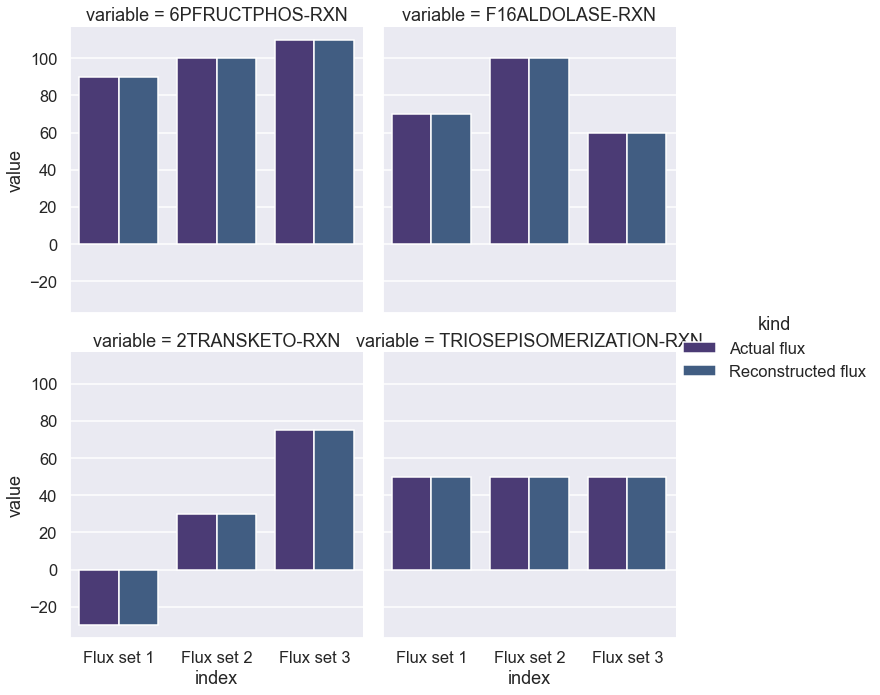

In [97]:
sns.catplot(x="index", y="value", hue="kind", col="variable", kind="bar", data=df_reconstr_comp, height=5, aspect=1, col_wrap=2)
plt.savefig("flux_set_comparison.svg")

# Add molecularity factor

In [98]:
Sd = pd.DataFrame(stoich_dict, dtype=np.int8).fillna(0).astype(np.int8)
# Sd = Sd.iloc[0:7, 0:2]

n_met = len(Sd.index)
n_rxn = len(Sd.columns)

Sd["6PFRUCTPHOS-RXN"] = Sd["6PFRUCTPHOS-RXN"] * 2
Sd

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
FRUCTOSE-6P,-2,0,1,0
ATP,-2,0,0,0
PROTON,2,0,0,0
ADP,2,0,0,0
FRUCTOSE-16-DIPHOSPHATE,2,-1,0,0
DIHYDROXY-ACETONE-PHOSPHATE,0,1,0,1
GAP,0,1,1,-1
ERYTHROSE-4P,0,0,-1,0
XYLULOSE-5-PHOSPHATE,0,0,-1,0


In [99]:
K_eq = np.log(keq)
K_eq_mod = K_eq[:, np.newaxis].T
vE = np.array([[90, 70, -30, 50], [100, 100, 30, 50], [110, 60, 75, 50]])
vE[:, 0] = vE[:, 0] / 2

n_flux_set = vE.shape[0]

# K_eq[vE < 0] = 1/K_eq[vE < 0]

lvE = np.log(np.abs(vE))
pd.DataFrame(np.concatenate([K_eq_mod, vE, np.sign(vE, dtype=np.int8)]), columns=Sd.columns,
             index=["$K_{eq}$", "$v_1$", "$v_2$", "$v_3$", "sign 1", "sign 2", "sign 3"])

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
$K_{eq}$,8.491991,-8.894527,2.398769,2.266298
$v_1$,45.000000,70.000000,-30.000000,50.000000
$v_2$,50.000000,100.000000,30.000000,50.000000
$v_3$,55.000000,60.000000,75.000000,50.000000
sign 1,1.000000,1.000000,-1.000000,1.000000
sign 2,1.000000,1.000000,1.000000,1.000000
sign 3,1.000000,1.000000,1.000000,1.000000


In [100]:
# set up variables

S_mol = np.array(Sd)
S = np.sign(S_mol) #
S_s = -np.copy(S) # reverse neg sign
S_p = np.copy(S)
S_s[S > 0] = 0 # zeros products
S_p[S < 0] = 0 # zeros substrates
S_i = np.copy(np.array(Sr) == -1) # reaction direction does not matter
S_a = np.copy(np.array(Sr) == 1)


S_s_nz = np.array(S_s.nonzero())
S_p_nz = np.array(S_p.nonzero())
S_i_nz = np.array(S_i.nonzero())
S_a_nz = np.array(S_a.nonzero())
S_s_mol = np.abs(S_mol)[S_s.nonzero()]
S_p_mol = np.abs(S_mol)[S_p.nonzero()]

# TODO Refactor all the below lines as one liners
# first coordinate, e.g. metabolites w nonzero substrate/product coeff across all reactions. also works as substrate indices.
met_s_nz = S_s_nz[0, :]
met_p_nz = S_p_nz[0, :]
met_i_nz = S_i_nz[0, :]
met_a_nz = S_a_nz[0, :]

# second coordinate, e.g. reactions indices for those concentrations. works to index substrates as well.
rxn_s_nz = S_s_nz[1, :]
rxn_p_nz = S_p_nz[1, :]
rxn_i_nz = S_i_nz[1, :]
rxn_a_nz = S_a_nz[1, :]

# one dim is always 2
n_Km_s = np.max(met_s_nz.shape)
n_Km_p = np.max(met_p_nz.shape)
n_Km_i = np.max(met_i_nz.shape)
n_Km_a = np.max(met_a_nz.shape)

c = cp.Variable([n_met, n_flux_set])
Km_s = cp.Variable(n_Km_s)
Km_p = cp.Variable(n_Km_p)
Km_i = cp.Variable(n_Km_i) if n_Km_i else None
Km_a = cp.Variable(n_Km_a) if n_Km_a else None

cfwd = cp.Variable(n_rxn)
crev = cp.Variable(n_rxn)

# define y vecs
y_s_t = []
y_p_t = []
y_i_t = []
y_a_t = []

# define Km positions by nonzero S matrix concentrations. Activation is reverse val of inhibition.
# TODO Add molecularity here.
for i in range(n_flux_set):
    y_s_t.append(cp.multiply(S_s_mol, c[met_s_nz, i] - Km_s))
    y_p_t.append(cp.multiply(S_p_mol, c[met_p_nz, i] - Km_p))
    y_i_t.append(c[met_i_nz, i] - Km_i if n_Km_i else None)
    y_a_t.append(-(c[met_a_nz, i] - Km_a) if n_Km_a else None)

y_s = cp.vstack(y_s_t)
y_p = cp.vstack(y_p_t)
y_i = cp.vstack(y_i_t)
y_a = cp.vstack(y_a_t)

# saturation stacks
y_f_vec = [y_s]
y_r_vec = [y_p]
if n_Km_i:
    y_f_vec.append(y_i)
    y_r_vec.append(y_i)
if n_Km_a:
    y_f_vec.append(y_a)
    y_r_vec.append(y_a)

y_f = cp.hstack(y_f_vec)
y_r = cp.hstack(y_r_vec)

In [101]:
# number of saturation terms for sub, prod
S_s_comb = np.concatenate((S_s, S_i, S_a), axis=0)
S_p_comb = np.concatenate((S_p, S_i, S_a), axis=0)
n_alpha = np.sum(np.power(2, np.sign(S_s_comb).sum(axis=0)) - 1)
n_beta = np.sum(np.power(2, np.sign(S_p_comb).sum(axis=0)) - 1)

# saturation matrix setup, first sub, then inhib, then act.
C_alpha = np.zeros([n_alpha, len(met_s_nz) + len(met_i_nz) + len(met_a_nz)])
C_beta = np.zeros([n_beta, len(met_p_nz) + len(met_i_nz) + len(met_a_nz)])

# to separate different reactions saturation terms to their individual reaction equations.
d_alpha = np.zeros(n_alpha, dtype=np.int8)
d_beta = np.zeros(n_beta, dtype=np.int8)


idx = 0

for i in range(n_rxn):

    # pick one reaction at a time (get substrate indicies)
    #idx_cur_rxn = rxn_s_nz == i
    # TODO This does not properly multiply by molecularity. Alternatively, generate C_alpha and
    # TODO beta without molecularity (first ==1) and then multiply by molecularity in the end.
    idx_cur_rxn = np.concatenate((rxn_s_nz == i, rxn_i_nz == i, rxn_a_nz == i))

    # generates all binary permutations minus the first one since that would result in -1
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]

    r, _ = sat_perm.shape

    # replace zeros with saturation matrix
    C_alpha[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_alpha[idx:(idx+r)] = i

    idx += r # add row #

idx = 0

for i in range(n_rxn):
    idx_cur_rxn = np.concatenate((rxn_p_nz == i, rxn_i_nz == i, rxn_a_nz == i))

    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]

    r, _ = sat_perm.shape

    C_beta[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_beta[idx:(idx+r)] = i

    idx += r # add row #

In [102]:
C_alpha

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

In [103]:
n_lse_terms = np.max(np.power(2, S_s.sum(axis=0)) +  np.power(2, S_p.sum(axis=0)) - 2)
LSE_expr = []
denom_expr = []

sign = np.sign(vE)
lvE = np.log(sign * vE)

for j in range(n_flux_set):
    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)

        n_term_s = np.sum(d_alpha == i)
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p

        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        if sign[j, i] == 1:
            LSE_expr.append(cp.hstack( [
                                         lvE[j, i] + (C_alpha @ cp.vec(y_f[j, :]))[d_alpha == i]
                                            - cp.multiply(np.ones(n_term_s), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) - cfwd[i],
                                         lvE[j, i] + (C_beta @ cp.vec(y_r[j, :]))[d_beta == i]
                                            - cp.multiply(np.ones(n_term_p), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) - cfwd[i],

                                         lvE[j, i] + 0 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  - cfwd[i],

                                         cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  + crev[i]
                                            - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  - cfwd[i],

                                       ]
                                     )
                           )  # remove +1 here, could also have cfwd outside objec.

            denom_expr.append(cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) + cfwd[i],)


        # keep saturation term the same, switch around fwd and rev terms. flip all signs with S matrix since it's signed.
        if sign[j, i] == -1:
            LSE_expr.append(cp.hstack( [ lvE[j, i] + (C_alpha @ cp.vec(y_f[j, :]))[d_alpha == i]
                                            - cp.multiply(np.ones(n_term_s), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                         lvE[j, i] + (C_beta @ cp.vec(y_r[j, :]))[d_beta == i]
                                            - cp.multiply(np.ones(n_term_p), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                         lvE[j, i] + 0 - cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                         cp.multiply(np.ones(1), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  + cfwd[i]
                                            - cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                       ]
                                     )
                           )

            denom_expr.append(cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) + crev[i])


#LSE_expr = cp.vstack(LSE_expr)
LSE_expr

[Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,)),
 Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,)),
 Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,))]

In [104]:
l = 0.001
e = 0.001
f = 0.000001
reg =  cp.sum(cp.hstack([cfwd, crev, cp.vec(c)])) + cp.sum(cp.hstack([-Km_s, -Km_p])) # regularization
reg2 = cp.norm1(cp.hstack([cfwd, crev, cp.vec(c)])) + cp.norm1(cp.hstack([-Km_s, -Km_p])) # regularization
reg3 = cp.sum(cp.huber(cp.hstack([y_s, y_p]), 1)) # issue with matrix

if n_Km_i:
    reg += cp.sum(cp.hstack([-Km_i]))
if n_Km_a:
    reg += cp.sum(cp.hstack([-Km_a]))
#reg3 = cp.norm1(cp.hstack([y_s, y_p])) # take a look at this

loss = 0
for i in range(len(LSE_expr)):
    loss += cp.norm1(cp.pos(cp.log_sum_exp(LSE_expr[i])))
for i in range(len(denom_expr)):
    loss += 0.01 * denom_expr[i]
loss += l * reg
loss += e * reg2
loss += f * reg3
#

In [105]:
constr = [cp.hstack([cfwd, crev, cp.vec(c), Km_s, Km_p]) >= -12,
          cp.hstack([cfwd, crev, cp.vec(c), Km_s, Km_p]) <= 12,
          ]

if n_Km_i:
    constr.extend([Km_i >= -12, Km_i <= 12])
if n_Km_a:
    constr.extend([Km_a >= -12, Km_a <= 12])



In [107]:
haldane = []
fwd_flux = []

for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

    haldane.append(K_eq[i] == cfwd[i] - crev[i] + r[S_p_idx] @ Km_p[Km_p_idx] - (-r[S_s_idx]) @ Km_s[Km_s_idx])

for j in range(n_flux_set):
    for i, r in enumerate(S.T):
        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        if sign[j, i] == 1:
            fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ cp.vec(y_s[j, Km_s_idx]) - (crev[i] + r[S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  >= 0)  # add minus since s matrix has minus

        if sign[j, i] == -1:
            fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ cp.vec(y_s[j, Km_s_idx]) - (crev[i] + r[S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  <= 0)  # add minus since s matrix has minus

    constr.extend([cp.multiply(S.T @ cp.vec(c[:, j]), sign[j, :])  <= cp.multiply(K_eq, sign[j, :])])

constr.extend(haldane)
constr.extend(fwd_flux)

In [1]:
p = cp.Problem(cp.Minimize(loss), constr)
p.solve(verbose=True, solver=cp.ECOS)

NameError: name 'cp' is not defined

In [109]:
print('Substrate Km:', [f'{val:.3f}' for val in np.exp(Km_s.value)])
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])

concs = np.exp(c.value).T
for row in concs:
    print('Concentration:', [f'{val:.4f}' for val in row])

if n_Km_i:
    print('Inhibition Km:', [f'{val:.3f}' for val in np.exp(Km_i.value)])
if n_Km_a:
    print('Activation Km:', [f'{val:.3f}' for val in np.exp(Km_a.value)])

Substrate Km: ['15.405', '2.714', '11.473', '1.058', '2.456', '2.456']
Product Km: ['74.476', '1.000', '2.224', '5.490', '0.033', '0.033', '1.000', '1.000']
Fwd kcat: ['16691.733', '1327.604', '4687.099', '847.466']
Rev kcat: ['1.000', '27643.302', '5257.662', '2.720']
Concentration: ['7.5190', '0.3478', '0.0161', '0.3199', '0.6842', '0.0000', '0.0664', '0.0004', '0.0004']
Concentration: ['2.8601', '1.0000', '0.0148', '0.3148', '1.0000', '0.0000', '0.0664', '0.2620', '0.2620']
Concentration: ['3.0064', '0.9850', '0.0152', '0.3160', '0.5823', '0.0000', '0.0664', '0.3988', '0.3988']
Activation Km: ['0.368', '0.006']


In [110]:
for v in LSE_expr:
    #print(v.value)
    print(logsumexp(v.value))

-3.888018841324836e-07
-6.322530571312157e-08
-4.755855434468437e-08
-7.837918723774262e-08
-3.510083170232825e-07
-5.385769247245875e-08
-8.229559989025859e-08
-3.262754130067824e-08
-3.623455192558467e-07
-6.395986819340838e-08
-7.819181951917997e-08
-3.6317813326136594e-08


Perfect? Wow.

# Check flux reconstruction with inhibition/activation

In [111]:
reconstructed_vE = np.zeros(vE.shape)

for j in range(n_flux_set):
    sat_expr = []
    fwd_sat = np.zeros(n_rxn)
    back_sat = np.zeros(n_rxn)
    sat = np.zeros(n_rxn)

    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
        n_term_s = np.sum(d_alpha == i)
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p


        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]

        sat_expr.append(           [ (C_alpha @ y_f.value[j, :].flatten())[d_alpha == i] ,
                                     (C_beta @ y_r.value[j, :].flatten())[d_beta == i],
                                     0,
                                     #-1*np.ones(n_lse_terms - n_term + 1)
                                   ]
                       )
        fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[j, Km_s_idx].flatten())) # + cfwd.value[i]
        back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[j, Km_p_idx].flatten())) # + cfwd.value[i]



    for i, rxn in enumerate(sat_expr):
        s = 0

        for term in rxn:
            s += np.sum(np.exp(term))

        sat[i] = (s)

    reconstr = np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat
    print(reconstr)
    reconstructed_vE[j, :] = reconstr

[ 45.0000175   70.00000445 -30.00000143  50.00000392]
[ 50.00001755 100.0000054   30.0000033   50.00000163]
[55.00001993 60.00000386 75.00000662 50.00000182]


In [112]:
df_vE = pd.DataFrame(vE, columns=Sd.columns, index=["Flux set 1", "Flux set 2", "Flux set 3"]).melt(ignore_index=False).reset_index(drop=False)
df_vE["kind"] = "Actual flux"
df_recon = pd.DataFrame(reconstructed_vE, columns=Sd.columns, index=["Flux set 1", "Flux set 2", "Flux set 3"]).melt(ignore_index=False).reset_index(drop=False)
df_recon["kind"] = "Reconstructed flux"

df_reconstr_comp = pd.concat([df_vE, df_recon]).reset_index(drop=True)
df_reconstr_comp

,index,variable,value,kind
0,Flux set 1,6PFRUCTPHOS-RXN,45.000000,Actual flux
1,Flux set 2,6PFRUCTPHOS-RXN,50.000000,Actual flux
2,Flux set 3,6PFRUCTPHOS-RXN,55.000000,Actual flux
3,Flux set 1,F16ALDOLASE-RXN,70.000000,Actual flux
4,Flux set 2,F16ALDOLASE-RXN,100.000000,Actual flux
5,Flux set 3,F16ALDOLASE-RXN,60.000000,Actual flux
6,Flux set 1,2TRANSKETO-RXN,-30.000000,Actual flux
7,Flux set 2,2TRANSKETO-RXN,30.000000,Actual flux
8,Flux set 3,2TRANSKETO-RXN,75.000000,Actual flux
9,Flux set 1,TRIOSEPISOMERIZATION-RXN,50.000000,Actual flux


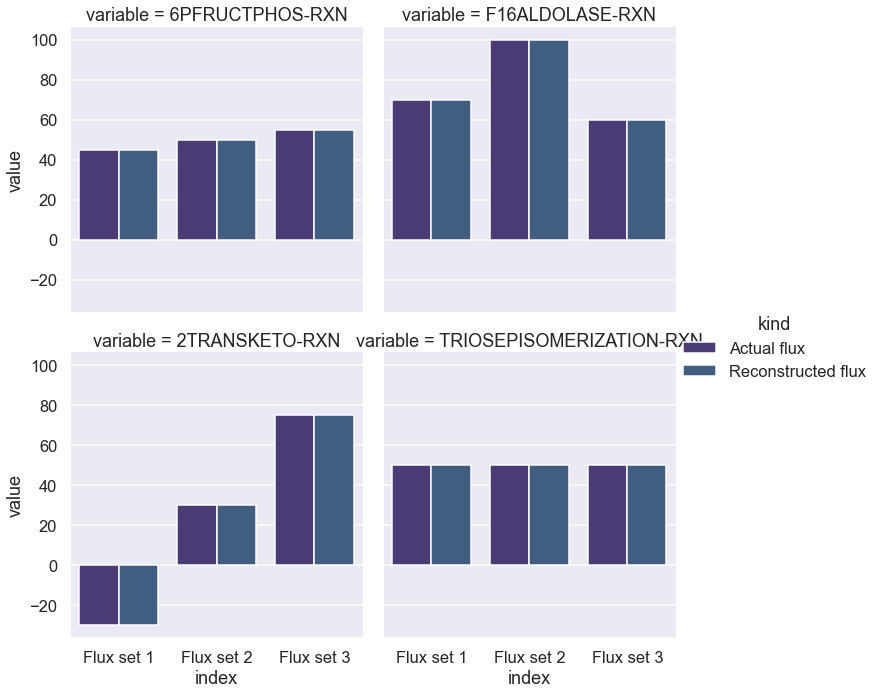

In [113]:
sns.catplot(x="index", y="value", hue="kind", col="variable", kind="bar", data=df_reconstr_comp, height=5, aspect=1, col_wrap=2)
plt.savefig("flux_set_comparison.svg")

# Create class based method

In [205]:
class ConvexKinetics:

    def __init__(self, S_matrix):

        self.regulation = False # TODO make this in a better way
        self.loss = 0
        self.constraints = []

        self.n_met = len(S_matrix.index)
        self.n_rxn = len(S_matrix.columns)

        S_mol = np.array(S_matrix)   # has molecularity
        self.S = np.sign(S_mol)      # has only +1 and -1 stoichiometries

        self.S_s, self.S_p = -np.copy(self.S), np.copy(self.S) # reverse neg sign
        self.S_s[self.S > 0] = 0 # zeros products
        self.S_p[self.S < 0] = 0 # zeros substrates

        self.S_s_nz = np.array(self.S_s.nonzero())    # substrate indices (metabolite, reaction)
        self.S_p_nz = np.array(self.S_p.nonzero())    # product indices (metabolite, reaction)
        self.S_s_mol = np.abs(S_mol)[self.S_s.nonzero()]  # substrate molecularity at indices
        self.S_p_mol = np.abs(S_mol)[self.S_p.nonzero()]  # product molecularity at indices

        # TODO Refactor all the below lines as one liners
        # first coordinate, e.g. metabolites w nonzero substrate/product coeff across all reactions. also works as substrate indices.
        self.met_s_nz, self.met_p_nz = self.S_s_nz[0, :], self.S_p_nz[0, :]     #

        # second coordinate, e.g. reactions indices for those concentrations. works to index substrates as well.
        self.rxn_s_nz, self.rxn_p_nz = self.S_s_nz[1, :], self.S_p_nz[1, :]

        # one dim is always 2
        n_Km_s, n_Km_p = len(self.met_s_nz), len(self.met_p_nz) # number of substrate and product Km

        self.Km_s, self.Km_p = cp.Variable(n_Km_s), cp.Variable(n_Km_p) # substrate and product Km
        self.cfwd, self.crev = cp.Variable(n_rxn), cp.Variable(n_rxn) # forward and reverse reaction rate constants

    def add_regulation(self, regulation_matrix):

        # TODO Assert that regulation matrix has same order of metabolites as S matrix

        Sr = regulation_matrix

        self.S_i = np.copy(np.array(Sr) == -1) # reaction direction does not matter
        self.S_a = np.copy(np.array(Sr) == 1)

        S_i_nz = np.array(self.S_i.nonzero())
        S_a_nz = np.array(self.S_a.nonzero())

        self.met_i_nz, self.met_a_nz = S_i_nz[0, :], S_a_nz[0, :]
        self.rxn_i_nz, self.rxn_a_nz = S_i_nz[1, :], S_a_nz[1, :]

        n_Km_i, n_Km_a = len(self.met_i_nz), len(self.met_a_nz)
        self.Km_i = cp.Variable(n_Km_i) if n_Km_i else None
        self.Km_a = cp.Variable(n_Km_a) if n_Km_a else None

        self.regulation = True

    def add_flow_data(self, flow_data):

        # TODO assert flux columns are identical to S_matrix columns
        self.n_flux_set = len(flow_data.index)
        self.flow_data = np.array(flow_data)

        self.c = cp.Variable([self.n_met, self.n_flux_set])    # concentrations

        y_s_t, y_p_t, y_i_t, y_a_t = [], [], [], []

        # define Km positions by nonzero S matrix concentrations. Activation is reverse val of inhibition.
        for i in range(self.n_flux_set):
            y_s_t.append(cp.multiply(self.S_s_mol, self.c[self.met_s_nz, i] - self.Km_s))
            y_p_t.append(cp.multiply(self.S_p_mol, self.c[self.met_p_nz, i] - self.Km_p))
            y_i_t.append(self.c[self.met_i_nz, i] - self.Km_i if self.Km_i else None)
            y_a_t.append(-(self.c[self.met_a_nz, i] - self.Km_a) if self.Km_a else None)

        self.y_s, self.y_p, self.y_i, self.y_a = cp.vstack(y_s_t), cp.vstack(y_p_t), cp.vstack(y_i_t), cp.vstack(y_a_t)

        y_f_vec, y_r_vec = [self.y_s], [self.y_p]
        if self.Km_i:
            y_f_vec.append(self.y_i)
            y_r_vec.append(self.y_i)
        if self.Km_a:
            y_f_vec.append(self.y_a)
            y_r_vec.append(self.y_a)

        self.y_f, self.y_r = cp.hstack(y_f_vec), cp.hstack(y_r_vec)

    def construct_binding_matrix(self):

        # number of saturation terms for sub, prod
        # make the code below cleaner
        S_s_comb = np.concatenate((self.S_s, self.S_i, self.S_a), axis=0)  if self.regulation else self.S_s
        S_p_comb = np.concatenate((self.S_p, self.S_i, self.S_a), axis=0) if self.regulation else self.S_p
        n_alpha = np.sum(np.power(2, np.sign(S_s_comb).sum(axis=0)) - 1)
        n_beta = np.sum(np.power(2, np.sign(S_p_comb).sum(axis=0)) - 1)

        # saturation matrix setup, first sub, then inhib, then act.
        C_alpha = np.zeros([n_alpha, len(self.met_s_nz) + len(self.met_i_nz) + len(self.met_a_nz)])
        C_beta = np.zeros([n_beta, len(self.met_p_nz) + len(self.met_i_nz) + len(self.met_a_nz)])

        # to separate different reactions saturation terms to their individual reaction equations.
        d_alpha, d_beta = np.zeros(n_alpha, dtype=np.int8), np.zeros(n_beta, dtype=np.int8)

        s_idx, p_idx = 0, 0

        for i in range(n_rxn):
            # pick one reaction at a time (get substrate indicies)
            idx_s_cur_rxn = np.concatenate((self.rxn_s_nz == i, self.rxn_i_nz == i, self.rxn_a_nz == i))
            idx_p_cur_rxn = np.concatenate((self.rxn_p_nz == i, self.rxn_i_nz == i, self.rxn_a_nz == i))

            # generates all binary permutations minus the first one since that would result in -1
            s_sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_s_cur_rxn))))[1:, :]
            p_sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_p_cur_rxn))))[1:, :]

            r_s, _ = s_sat_perm.shape
            r_p, _ = p_sat_perm.shape

            # replace zeros with saturation matrix
            C_alpha[s_idx:(s_idx+r_s), idx_s_cur_rxn] = s_sat_perm
            d_alpha[s_idx:(s_idx+r_s)] = i

            C_beta[p_idx:(p_idx+r_p), idx_p_cur_rxn] = p_sat_perm
            d_beta[p_idx:(p_idx+r_p)] = i

            s_idx += r_s # add number of rows added.
            p_idx += r_p #

        self.C_alpha, self.C_beta, self.d_alpha, self.d_beta = C_alpha, C_beta, d_alpha, d_beta

    def construct_kinetic_objective(self):

        # TODO
        LSE_expr, denom_expr = [], []

        sign = np.sign(self.flow_data)
        lvE = np.log(sign * self.flow_data)

        for j in range(self.n_flux_set):
            for i in range(self.n_rxn):
                # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)

                Km_s_idx = np.nonzero(self.rxn_s_nz == i) # TODO have to set as attribute
                S_s_idx = self.S_s_nz[0, self.rxn_s_nz == i] # negate -1 entries

                Km_p_idx = np.nonzero(self.rxn_p_nz == i)
                S_p_idx = self.S_p_nz[0, self.rxn_p_nz == i]

                if sign[j, i] == 1:
                    expr_num = [
                                lvE[j, i] + (self.C_alpha @ cp.vec(self.y_f[j, :]))[self.d_alpha == i],
                                lvE[j, i] + (self.C_beta @ cp.vec(self.y_r[j, :]))[self.d_beta == i],
                                lvE[j, i] + 0,
                                self.S.T[i, S_p_idx] @ cp.vec(self.y_p[j, Km_p_idx])  + self.crev[i] # TODO did removing multiply break this?
                                ] # TODO first three terms are the same. can be combined outside if statement

                    expr_denom = - (- self.S.T[i, S_s_idx] @ cp.vec(self.y_s[j, Km_s_idx])) - self.cfwd[i]
                    expr = cp.hstack(expr_num) + expr_denom # TODO this might be wrong
                    LSE_expr.append(expr) # TODO vectorize this

                    denom_expr.append(-expr_denom) # TODO vectorize this


                # keep saturation term the same, switch around fwd and rev terms. flip all signs with S matrix since it's signed.
                if sign[j, i] == -1:
                    expr_num = [
                                lvE[j, i] + (self.C_alpha @ cp.vec(self.y_f[j, :]))[self.d_alpha == i],
                                lvE[j, i] + (self.C_beta @ cp.vec(self.y_r[j, :]))[self.d_beta == i],
                                lvE[j, i] + 0,
                                - self.S.T[i, S_s_idx] @ cp.vec(self.y_s[j, Km_s_idx]) + self.cfwd[i]
                                ]

                    expr_denom = - (self.S.T[i, S_p_idx] @ cp.vec(self.y_p[j, Km_p_idx])) - self.crev[i]
                    expr = cp.hstack(expr_num) + expr_denom # TODO this might be wrong

                    LSE_expr.append(expr)

                    denom_expr.append(cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) + crev[i])

            self.LSE_expr, self.denom_expr = LSE_expr, denom_expr

    def create_objective_function(self, prior_weight = 0.0001, l1_weight = 0.0001, denom_weight = 0.01):

        p = prior_weight
        l1 = l1_weight
        l1_term =  cp.sum(cp.hstack([self.cfwd, self.crev, cp.vec(self.c)])) + cp.sum(cp.hstack([-self.Km_s, -self.Km_p])) # regularization (l1 because geometric)
        p_term = cp.norm1(cp.hstack([self.cfwd, self.crev, cp.vec(self.c)])) + cp.norm1(cp.hstack([-self.Km_s, -self.Km_p])) # regularization # TODO these are conflicting also prior

        if self.Km_i is not None:
            l1_term += cp.sum(cp.hstack([-self.Km_i]))
        if self.Km_a is not None:
            l1_term += cp.sum(cp.hstack([-self.Km_a])) # TODO this might break if no Km

        for i in range(len(self.LSE_expr)):
            self.loss += cp.norm1(cp.pos(cp.log_sum_exp(self.LSE_expr[i])))
        for i in range(len(self.denom_expr)):
            self.loss += denom_weight * self.denom_expr[i]

        self.loss += l1 * l1_term + p * p_term

    def set_parameter_bounds(self, lower_bound = -12, upper_bound = 12):

        self.constraints.append(cp.hstack([self.cfwd, self.crev, cp.vec(self.c), self.Km_s, self.Km_p]) >= lower_bound)
        self.constraints.append(cp.hstack([self.cfwd, self.crev, cp.vec(self.c), self.Km_s, self.Km_p]) <= upper_bound) # TODO might be append lol

        if self.Km_i:
            self.constraints.extend([self.Km_i >= -lower_bound, self.Km_i <= upper_bound])
        if self.Km_a:
            self.constraints.extend([self.Km_a >= -lower_bound, self.Km_a <= upper_bound])

    def add_mechanistic_constraints(self, K_eq):

        # TODO Assert that order of K_eq is the same as order of self.S (dict)
        sign = np.sign(self.flow_data)
        haldane = []
        fwd_flux = []

        for i, r in enumerate(self.S.T):    # TODO do this for kinetic objective creation
            Km_s_idx = np.nonzero(self.rxn_s_nz == i) # TODO have to set as attribute
            S_s_idx = self.S_s_nz[0, self.rxn_s_nz == i] # negate -1 entries

            Km_p_idx = np.nonzero(self.rxn_p_nz == i)
            S_p_idx = self.S_p_nz[0, self.rxn_p_nz == i]

            haldane.append(K_eq[i] == self.cfwd[i] - self.crev[i] + r[S_p_idx] @ self.Km_p[Km_p_idx] - (-r[S_s_idx]) @ self.Km_s[Km_s_idx])

        for j in range(self.n_flux_set):
            for i, r in enumerate(self.S.T): # TODO use the above for loop
                Km_s_idx = np.nonzero(self.rxn_s_nz == i) # TODO have to set as attribute
                S_s_idx = self.S_s_nz[0, self.rxn_s_nz == i] # negate -1 entries

                Km_p_idx = np.nonzero(self.rxn_p_nz == i)
                S_p_idx = self.S_p_nz[0, self.rxn_p_nz == i]

                if sign[j, i] == 1:
                    fwd_flux.append(self.cfwd[i] + (-r[S_s_idx]) @ cp.vec(self.y_s[j, Km_s_idx])
                                    - (self.crev[i] + r[S_p_idx] @ cp.vec(self.y_p[j, Km_p_idx]))  >= 0)  # add minus since s matrix has minus

                if sign[j, i] == -1:
                    fwd_flux.append(self.cfwd[i] + (-r[S_s_idx]) @ cp.vec(self.y_s[j, Km_s_idx])
                                    - (self.crev[i] + r[S_p_idx] @ cp.vec(self.y_p[j, Km_p_idx]))  <= 0)  # add minus since s matrix has minus

            self.constraints.extend([cp.multiply(self.S.T @ cp.vec(self.c[:, j]), sign[j, :])  <= cp.multiply(K_eq, sign[j, :])])

        self.constraints.extend(haldane)
        self.constraints.extend(fwd_flux)

    def solve(self, solver = cp.ECOS, verbose = False, **kwargs):

        self.problem = cp.Problem(cp.Minimize(self.loss), self.constraints)
        self.problem.solve(solver = solver, verbose = verbose, **kwargs)


In [206]:
E = ConvexKinetics(Sd)

In [207]:
E.add_regulation(Sr)

In [208]:
E.add_flow_data(pd.DataFrame(np.array([vE])))

In [209]:
E.construct_binding_matrix()

In [210]:
E.construct_kinetic_objective()

In [211]:
E.create_objective_function()

In [212]:
E.set_parameter_bounds()

In [213]:
E.add_mechanistic_constraints(K_eq)

In [215]:
E.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Apr 18 09:57:18 AM: Your problem has 33 variables, 13 constraints, and 0 parameters.
(CVXPY) Apr 18 09:57:18 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 18 09:57:18 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 18 09:57:18 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 18 09:57:18 AM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 18 09:57:18 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

In [132]:
Sr

# define y vecs
# make the code below more efficient


,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
FRUCTOSE-6P,1,0,0,0
ATP,0,0,0,0
PROTON,0,0,0,0
ADP,1,0,0,0
FRUCTOSE-16-DIPHOSPHATE,0,0,0,0
DIHYDROXY-ACETONE-PHOSPHATE,0,0,0,0
GAP,0,0,0,0
ERYTHROSE-4P,0,0,0,0
XYLULOSE-5-PHOSPHATE,0,0,0,0


In [ ]:
haldane = []
fwd_flux = []

for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

    haldane.append(K_eq[i] == cfwd[i] - crev[i] + r[S_p_idx] @ Km_p[Km_p_idx] - (-r[S_s_idx]) @ Km_s[Km_s_idx])

for j in range(n_flux_set):
    for i, r in enumerate(S.T):
        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        if sign[j, i] == 1:
            fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ cp.vec(y_s[j, Km_s_idx]) - (crev[i] + r[S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  >= 0)  # add minus since s matrix has minus

        if sign[j, i] == -1:
            fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ cp.vec(y_s[j, Km_s_idx]) - (crev[i] + r[S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  <= 0)  # add minus since s matrix has minus

    constr.extend([cp.multiply(S.T @ cp.vec(c[:, j]), sign[j, :])  <= cp.multiply(K_eq, sign[j, :])])

constr.extend(haldane)
constr.extend(fwd_flux)